#Notebook Summary: 7Days_LOS_Classification

This notebook, originally generated in Google Colab, implements a machine learning workflow to classify hospital length of stay (LOS) for diabetic patients using data from a 7-day observation window. Key aspects include:

##Setup & Imports:
The notebook installs and imports essential libraries such as scikit-learn, XGBoost, pandas, NumPy, matplotlib, seaborn, and Optuna for hyperparameter tuning.

####Data Loading & Preprocessing:
The dataset ("MC_merged.csv") is loaded and preprocessed by dropping irrelevant columns and defining a binary target variable (below vs. above median LOS). The features are split into two groups: pattern-based features (identified by specific column prefixes) and baseline features. Three different feature sets are then created: one with only pattern-based features, one with only static features, and one combining both.

##Model Training & Evaluation:
The notebook trains three classifiers—Random Forest, SVM, and XGBoost—using Optuna for hyperparameter optimization. For each classifier, the data is split into training and testing sets; scaling (particularly for SVM) and SMOTE (for handling class imbalance in XGBoost) are applied as necessary. The models are evaluated on metrics including Accuracy, Precision, Recall, F1 Score, and AUC-ROC.

##Performance Metrics:
The evaluation metrics provide a comprehensive comparison of the classification performance using the 7-day data, helping to assess the impact of temporal features and feature integration on LOS prediction.

This notebook is part of a broader research effort to assess the utility of temporal abstraction and feature integration for LOS classification. All code and procedures are provided for reproducibility and further exploration.

In [ ]:
# Install required packages
!pip install xgboost
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install --upgrade xgboost
!pip install optuna scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import optuna

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
)

# Load the dataset
df = pd.read_csv("MC.csv")  # Ensure the dataset is uploaded in Colab
df = df.drop(columns=["TotalHospitalDays", "Unnamed: 0"])
# Define target variable (y)
y = df["value"]  # Target: 0 (below median), 1 (above median)

# Identify columns for different cases
pattern_columns = [col for col in df.columns if col.startswith("@@Pair")]
static_columns = [col for col in df.columns if col not in pattern_columns + ["value", "Total_Dosage", "PatientNum"]]

# Create different feature sets
X_patterns_only = df[pattern_columns]  # Only pattern-based features
X_static_only = df[static_columns]  # Only static features
X_combined = df.drop(columns=["value", "Total_Dosage", "PatientNum"])  # Use all features


#RANDOM FOREST

In [ ]:
# Define the Optuna optimization function
def objective(trial, X_train, X_test, y_train, y_test):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # Optimize for accuracy

# Function to train and evaluate a Random Forest model with Optuna tuning
def train_and_evaluate(X, y, dataset_name):
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Run Optuna optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=30)  # 30 trials

    # Get best hyperparameters
    best_params = study.best_params
    print(f"\n🎯 Best Hyperparameters for {dataset_name}:")
    print(best_params)

    # Train the best model
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate Performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print Evaluation Metrics
    print(f"\n📊 Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_roc:.4f}")



# Train and evaluate for each dataset using Optuna-optimized Random Forest
train_and_evaluate(X_patterns_only, y, "Pattern-Based Features")
train_and_evaluate(X_static_only, y, "Static-Based Features")
train_and_evaluate(X_combined, y, "Combined Features")

[I 2025-02-28 13:13:50,352] A new study created in memory with name: no-name-09d8b551-aa14-4d16-a3ac-9ae8f1cf86b3
[I 2025-02-28 13:13:50,496] Trial 0 finished with value: 0.5465116279069767 and parameters: {'n_estimators': 83, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.5465116279069767.
[I 2025-02-28 13:13:50,750] Trial 1 finished with value: 0.5523255813953488 and parameters: {'n_estimators': 201, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.5523255813953488.
[I 2025-02-28 13:13:50,897] Trial 2 finished with value: 0.5523255813953488 and parameters: {'n_estimators': 83, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 0.5523255813953488.
[I 2025-02-28 13:13:51,518] Trial 3 finished with value: 0.5523255813953488 and parameters: {'n_estimators': 388, 'max_depth': 27, 'min_samples_split


🎯 Best Hyperparameters for Pattern-Based Features:
{'n_estimators': 201, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': False}


[I 2025-02-28 13:14:02,480] A new study created in memory with name: no-name-b51e9cb9-2e15-4ff5-8cdf-a57a8df19104



📊 Results for Pattern-Based Features:
Accuracy: 0.5523
Precision: 0.7778
Recall: 0.1609
F1 Score: 0.2667
AUC-ROC Score: 0.5642


[I 2025-02-28 13:14:02,939] Trial 0 finished with value: 0.6918604651162791 and parameters: {'n_estimators': 234, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.6918604651162791.
[I 2025-02-28 13:14:03,481] Trial 1 finished with value: 0.6802325581395349 and parameters: {'n_estimators': 278, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.6918604651162791.
[I 2025-02-28 13:14:04,321] Trial 2 finished with value: 0.7209302325581395 and parameters: {'n_estimators': 425, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 2 with value: 0.7209302325581395.
[I 2025-02-28 13:14:04,719] Trial 3 finished with value: 0.6918604651162791 and parameters: {'n_estimators': 237, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 0.7209302325581395.
[I 2025-02-28 


🎯 Best Hyperparameters for Static-Based Features:
{'n_estimators': 228, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}


[I 2025-02-28 13:14:26,647] A new study created in memory with name: no-name-364fd973-3a79-418c-a2b4-b20700651186



📊 Results for Static-Based Features:
Accuracy: 0.7326
Precision: 0.7253
Recall: 0.7586
F1 Score: 0.7416
AUC-ROC Score: 0.7263


[I 2025-02-28 13:14:27,409] Trial 0 finished with value: 0.6744186046511628 and parameters: {'n_estimators': 360, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.6744186046511628.
[I 2025-02-28 13:14:28,245] Trial 1 finished with value: 0.7267441860465116 and parameters: {'n_estimators': 464, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 0.7267441860465116.
[I 2025-02-28 13:14:28,915] Trial 2 finished with value: 0.7034883720930233 and parameters: {'n_estimators': 376, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.7267441860465116.
[I 2025-02-28 13:14:29,710] Trial 3 finished with value: 0.6976744186046512 and parameters: {'n_estimators': 369, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.7267441860465116.
[I 2025-02-28 1


🎯 Best Hyperparameters for Combined Features:
{'n_estimators': 331, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}

📊 Results for Combined Features:
Accuracy: 0.7384
Precision: 0.7143
Recall: 0.8046
F1 Score: 0.7568
AUC-ROC Score: 0.7469


#SVM

[I 2025-02-28 13:14:46,856] A new study created in memory with name: no-name-b22fe67c-2424-44f7-8092-c502b165d2a3
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.01, 100),
<ipython-input-8-1e6e3166dba6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 0.0001, 1),
[I 2025-02-28 13:14:46,896] Trial 0 finished with value: 0.5406976744186046 and parameters: {'C': 14.975374791391586, 'gamma': 0.0010686843192970951, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5406976744186046.
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been deprecate


🎯 Best Hyperparameters for Pattern-Based Features (SVM):
{'C': 1.9089020508650643, 'gamma': 0.3266049222434597, 'kernel': 'sigmoid'}

📊 Results for Pattern-Based Features (SVM):
Accuracy: 0.5581
Precision: 0.7895
Recall: 0.1724
F1 Score: 0.2830
AUC-ROC Score: 0.5602


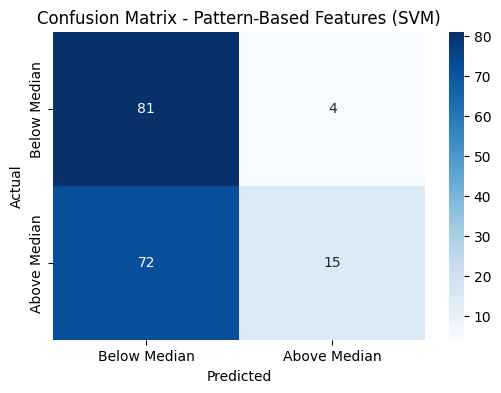

[I 2025-02-28 13:14:48,672] A new study created in memory with name: no-name-5c32e644-33eb-440f-980d-6ec21e209f0a
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.01, 100),
<ipython-input-8-1e6e3166dba6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 0.0001, 1),
[I 2025-02-28 13:14:48,726] Trial 0 finished with value: 0.6511627906976745 and parameters: {'C': 6.241853265299422, 'gamma': 0.023511358114346233, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.6511627906976745.
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been depreca


🎯 Best Hyperparameters for Static-Based Features (SVM):
{'C': 24.386852929055873, 'gamma': 0.0032369588815269676, 'kernel': 'rbf'}

📊 Results for Static-Based Features (SVM):
Accuracy: 0.6686
Precision: 0.7143
Recall: 0.5747
F1 Score: 0.6369
AUC-ROC Score: 0.7380


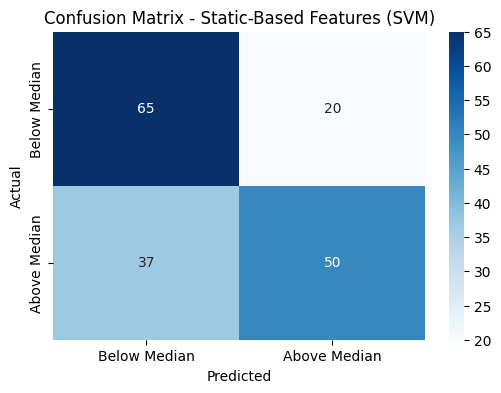

[I 2025-02-28 13:14:51,007] A new study created in memory with name: no-name-58792aa2-1933-495f-81e6-c81b824b2a55
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.01, 100),
<ipython-input-8-1e6e3166dba6>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 0.0001, 1),
[I 2025-02-28 13:14:51,056] Trial 0 finished with value: 0.5406976744186046 and parameters: {'C': 0.10097093110814925, 'gamma': 0.2567243306935614, 'kernel': 'poly'}. Best is trial 0 with value: 0.5406976744186046.
<ipython-input-8-1e6e3166dba6>:4: FutureWarning: suggest_loguniform has been deprecated


🎯 Best Hyperparameters for Combined Features (SVM):
{'C': 1.8743983560340889, 'gamma': 0.006506400312418599, 'kernel': 'sigmoid'}

📊 Results for Combined Features (SVM):
Accuracy: 0.6744
Precision: 0.7541
Recall: 0.5287
F1 Score: 0.6216
AUC-ROC Score: 0.7154


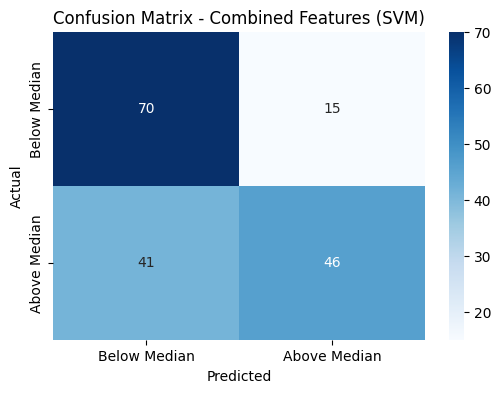

In [ ]:


# Define the Optuna optimization function for SVM
def objective_svm(trial, X_train, X_test, y_train, y_test):
    params = {
        "C": trial.suggest_loguniform("C", 0.01, 100),
        "gamma": trial.suggest_loguniform("gamma", 0.0001, 1),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
    }

    model = SVC(**params, probability=True, random_state=42)

    # Scale data for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # Optimize for accuracy

# Function to train and evaluate an SVM model with Optuna tuning
def train_and_evaluate_svm(X, y, dataset_name):
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Run Optuna optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_svm(trial, X_train, X_test, y_train, y_test), n_trials=30)  # 30 trials

    # Get best hyperparameters
    best_params = study.best_params
    print(f"\n🎯 Best Hyperparameters for {dataset_name} (SVM):")
    print(best_params)

    # Train the best model
    best_model = SVC(**best_params, probability=True, random_state=42)

    # Scale data for SVM
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate Performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print Evaluation Metrics
    print(f"\n📊 Results for {dataset_name} (SVM):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_roc:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Below Median", "Above Median"], yticklabels=["Below Median", "Above Median"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {dataset_name} (SVM)")
    plt.show()

# Train and evaluate for each dataset using Optuna-optimized SVM
train_and_evaluate_svm(X_patterns_only, y, "Pattern-Based Features")
train_and_evaluate_svm(X_static_only, y, "Static-Based Features")
train_and_evaluate_svm(X_combined, y, "Combined Features")


#XGBoost

In [ ]:
def objective_xgb(trial, X_train, X_test, y_train, y_test):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0)
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # Optimize for accuracy

# Function to train and evaluate an XGBoost model with Optuna tuning
def train_and_evaluate_xgb_optuna(X, y, dataset_name):
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Scale features (helps in gradient boosting)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run Optuna optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_xgb(trial, X_train, X_test, y_train, y_test), n_trials=30)  # 30 trials

    # Get best hyperparameters
    best_params = study.best_params
    print(f"\n🎯 Best Hyperparameters for {dataset_name} (XGBoost):")
    print(best_params)

    # Train the best model
    best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")

    best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict on test data
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate Performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print Evaluation Metrics
    print(f"\n📊 Results for {dataset_name} (XGBoost):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_roc:.4f}")


# Train and evaluate for each dataset using Optuna-optimized XGBoost
train_and_evaluate_xgb_optuna(X_patterns_only, y, "Pattern-Based Features")
train_and_evaluate_xgb_optuna(X_static_only, y, "Static-Based Features")
train_and_evaluate_xgb_optuna(X_combined, y, "Combined Features")

[I 2025-02-28 13:14:53,275] A new study created in memory with name: no-name-de25e1be-ec73-4c40-a139-baf19c784b27
<ipython-input-9-dd52c16d5937>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-28 13:14:53,325] Trial 0 finished with value: 0.5058139534883721 and parameters: {'n_estimators': 147, 'learning_rate': 0.17325145916260187, 'max_depth': 9, 'subsample': 0.6016504406567659, 'colsample_bytree': 0.7557657254024931, 'gamma': 3.5248981894613314, 'reg_alpha': 3.897840727150565, 'reg_lambda': 0.03072277050621741}. Best is trial 0 with val


🎯 Best Hyperparameters for Pattern-Based Features (XGBoost):
{'n_estimators': 167, 'learning_rate': 0.29034456044486323, 'max_depth': 4, 'subsample': 0.7485069476929391, 'colsample_bytree': 0.8516414111697289, 'gamma': 2.526568004899726, 'reg_alpha': 0.11370711573267396, 'reg_lambda': 2.579807801955943}

📊 Results for Pattern-Based Features (XGBoost):
Accuracy: 0.5581
Precision: 0.7895
Recall: 0.1724
F1 Score: 0.2830
AUC-ROC Score: 0.5640


[I 2025-02-28 13:14:56,468] Trial 0 finished with value: 0.7209302325581395 and parameters: {'n_estimators': 474, 'learning_rate': 0.044083938104923975, 'max_depth': 6, 'subsample': 0.6736437082225706, 'colsample_bytree': 0.7612244349635486, 'gamma': 1.8960221016929952, 'reg_alpha': 2.955047655255034, 'reg_lambda': 4.0251338553131415}. Best is trial 0 with value: 0.7209302325581395.
<ipython-input-9-dd52c16d5937>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-28 13:14:56,659] Trial 1 finished with value: 0.6976744186046512 and parameters


🎯 Best Hyperparameters for Static-Based Features (XGBoost):
{'n_estimators': 79, 'learning_rate': 0.01820502726267642, 'max_depth': 10, 'subsample': 0.8589584520568212, 'colsample_bytree': 0.7792148952090958, 'gamma': 0.37816259090864945, 'reg_alpha': 3.8993777391913214, 'reg_lambda': 4.813092289937455}

📊 Results for Static-Based Features (XGBoost):
Accuracy: 0.7267
Precision: 0.7083
Recall: 0.7816
F1 Score: 0.7432
AUC-ROC Score: 0.7227


<ipython-input-9-dd52c16d5937>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:15:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-28 13:15:03,920] Trial 0 finished with value: 0.7267441860465116 and parameters: {'n_estimators': 499, 'learning_rate': 0.039013662761819654, 'max_depth': 8, 'subsample': 0.9382315284069094, 'colsample_bytree': 0.7581493957307122, 'gamma': 3.408426490804301, 'reg_alpha': 4.858268533633942, 'reg_lambda': 3.6410088666318234}. Best is trial 0 with value: 0.7267441860465116.
<ipython-input-9-dd52c16d5937>:4: FutureWarning: suggest_loguniform has been deprecated in 


🎯 Best Hyperparameters for Combined Features (XGBoost):
{'n_estimators': 472, 'learning_rate': 0.01012644953777604, 'max_depth': 10, 'subsample': 0.774128173885058, 'colsample_bytree': 0.6824055598110013, 'gamma': 1.8796676648902202, 'reg_alpha': 2.714766602438388, 'reg_lambda': 2.842597430750325}

📊 Results for Combined Features (XGBoost):
Accuracy: 0.7384
Precision: 0.7333
Recall: 0.7586
F1 Score: 0.7458
AUC-ROC Score: 0.7382
